In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from xgboost import XGBClassifier
import seaborn as sns
import re
import torch
import os
from torch import nn
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments, DataCollatorWithPadding,AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset
from tqdm import tqdm
from numpy.linalg import norm
from scipy.sparse import hstack, csr_matrix
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df_train = pd.read_csv("/content/drive/MyDrive/Machine Learning/Data/quora_question_pairs_train.csv.zip")
df_test = pd.read_csv("/content/drive/MyDrive/Machine Learning/Data/quora_question_pairs_test.csv.zip")

Mounted at /content/drive


In [ ]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three indepen...,0
1,196656,297402,297403,What is practical management and what is strat...,What are the practical aspects of strategic ma...,0
2,113125,184949,184950,How useful is MakeUseOf Answers?,Is there any Q&A site that is not Yahoo answer...,0
3,266232,101283,163744,Which is the best place to reside in India and...,Which ia the best place to visit in India?,0
4,122738,17811,27517,Why do so many people ask questions on Quora t...,Why don't many people posting questions on Quo...,1


# Exploratory Data Analysis

Let's check number of records in train and test datasets:

In [ ]:
df_train.shape, df_test.shape

((323432, 6), (80858, 6))

Let's check the distribution of classes in both datasets:

In [ ]:
print('Train:\n', df_train.is_duplicate.value_counts(normalize=True), '\nTest:\n', df_test.is_duplicate.value_counts(normalize=True))

Train:
 is_duplicate
0    0.630803
1    0.369197
Name: proportion, dtype: float64 
Test:
 is_duplicate
0    0.630797
1    0.369203
Name: proportion, dtype: float64


Let's check if there're any missing values in the datasets:

In [ ]:
df_train.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


In [ ]:
df_test.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [3]:
# Dropping the records with missing values from the train dataset
df_train.dropna(inplace=True)
df_train.reset_index(inplace=True)

Let's analyze question length distribution in the train dataset:

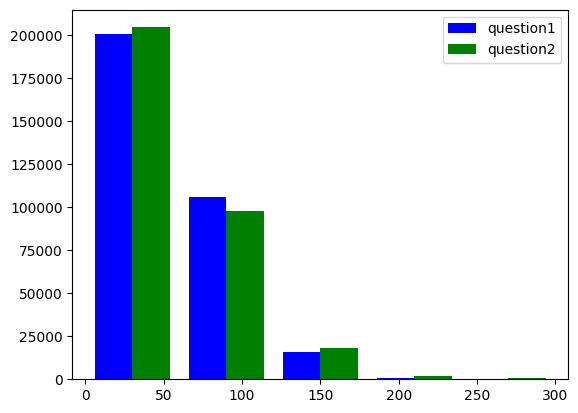

In [ ]:
plt.hist([df_train.question1.str.len(), df_train.question2.str.len()], bins=5, range=(0, 300), label=['question1', 'question2'], color=['b','g'])
plt.legend(loc='upper right')
plt.show()

Both question sets have the majority of values clustered around the lower range (with ~60% of questions being under 50 symbols), indicating that most questions are short. Both sets have a comparable length distribution.

# Data preprocessing


Text data preprocessing is essential for transforming raw text into numerical formats that machine learning models can understand. We'll use TF-IDF and BERT embeddings here.

In [4]:
text_cols = ['question1', 'question2']

X_train = df_train[text_cols]
y_train = df_train.is_duplicate
X_test = df_test[text_cols]
y_test = df_test.is_duplicate

## TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) is a method to represent text data numerically by evaluating the importance of each word in a document relative to its frequency across the entire dataset. The "Term Frequency" (TF) captures how frequently a word appears in a document, while the "Inverse Document Frequency" (IDF) downweights common words that appear frequently across multiple documents. TF-IDF scores help to capture the unique characteristics of a document, making it easier for algorithms to differentiate between texts.

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [ ]:
# Custom tokenizer function
def tokenize(text):
    # Lowercase the text
    text = text.lower()

    # Remove URLs, mentions, hashtags, and other common patterns
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)

    # Remove punctuation and special characters
    text = re.sub(r"[^\w\s]", "", text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

In [ ]:
vectorizer = TfidfVectorizer(lowercase=True,
                             ngram_range=(1, 2),
                             max_features=5000,
                             tokenizer=tokenize,
                             token_pattern=None
)

In [ ]:
# Combine the two text columns into a single column
X_train_combined = df_train['question1'] + ' ' + df_train['question2']

# Now fit and transform the combined text
X_train_tfidf = vectorizer.fit_transform(X_train_combined)

In [ ]:
X_test_combined = df_test['question1'] + ' ' + df_test['question2']

X_test_tfidf = vectorizer.transform(X_test_combined)

## Bert Embeddings

BERT (Bidirectional Encoder Representations from Transformers) is a transformer-based model that generates deep contextual embeddings for text by capturing semantic relationships in both directions (left-to-right and right-to-left). BERT embeddings provide a dense representation of each text that reflects not only word meanings but also their context within the sentence. These embeddings are especially useful for tasks like similarity detection, sentiment analysis, and question answering due to their ability to capture nuanced meanings in text.

In [ ]:
# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def get_bert_embeddings_batch(text_list):
    """
    Generates BERT embeddings for a batch of text input.

    Args:
        text_list (List[str]): A list of text strings to be processed.

    Returns:
        torch.Tensor: A tensor of CLS token embeddings for each text input in the batch.
    """
    # Tokenize the input text
    inputs = tokenizer(text_list, return_tensors="pt", padding=True, truncation=True, max_length=128)
    # Move inputs to GPU
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the CLS token embeddings and move to CPU
    cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu()
    return cls_embeddings

In [ ]:
def batch_process_embeddings(X, batch_size=100):
    """
    Processes input text in batches to generate BERT embeddings for two columns in a DataFrame.

    Args:
        X (pd.DataFrame): The input DataFrame containing two columns ('question1' and 'question2') of text data.
        batch_size (int): Number of samples to process in each batch.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Tensors containing embeddings for 'question1' and 'question2'.
    """
    # Process each column in batches
    all_embeddings_q1 = []
    all_embeddings_q2 = []

    for start in tqdm(range(0, len(X), batch_size)):
        end = start + batch_size
        batch_q1 = X['question1'][start:end].tolist()
        batch_q2 = X['question2'][start:end].tolist()

        # Get BERT embeddings for each batch of question1 and question2
        embeddings_q1 = get_bert_embeddings_batch(batch_q1)
        embeddings_q2 = get_bert_embeddings_batch(batch_q2)

        # Append embeddings for this batch to the list
        all_embeddings_q1.append(embeddings_q1)
        all_embeddings_q2.append(embeddings_q2)

    # Concatenate all batches into a single tensor for each question
    all_embeddings_q1 = torch.cat(all_embeddings_q1)
    all_embeddings_q2 = torch.cat(all_embeddings_q2)

    return all_embeddings_q1, all_embeddings_q2

In [ ]:
train_embeddings_q1, train_embeddings_q2 = batch_process_embeddings(X_train)
test_embeddings_q1, test_embeddings_q2 = batch_process_embeddings(X_test)

In [ ]:
np.save('train_embeddings_q1.npy', train_embeddings_q1.numpy())
np.save('train_embeddings_q2.npy', train_embeddings_q2.numpy())
np.save('test_embeddings_q1.npy', test_embeddings_q1.numpy())
np.save('test_embeddings_q2.npy', test_embeddings_q2.numpy())

# Baseline Models

Let's train some models (Logistic Regression, Naive Bayes and XGBoost) on TF-IDF embeddings to get a sense of baseline performance:

In [17]:
def train_compute_metrics_cv(model, X, y, cv=5):
    """
    Performs cross-validation training and evaluation on a classification model, computing metrics across folds.

    Args:
        model (sklearn.base.BaseEstimator): The classification model to be trained and evaluated.
        X (np.ndarray or pd.DataFrame): Feature matrix containing input data.
        y (np.ndarray or pd.Series): Target labels for classification.
        cv (int): Number of cross-validation folds, default is 5.

    Returns:
        None
    """
    # Initialize lists to store metrics
    logloss_train_scores, precision_train_scores, recall_train_scores, f1_train_scores = [], [], [], []
    logloss_val_scores, precision_val_scores, recall_val_scores, f1_val_scores = [], [], [], []
    cm_abs_total = np.zeros((2, 2), dtype=int)
    cm_percentage_total = np.zeros((2, 2), dtype=float)

    # Set up cross-validation
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X, y):
        # Split the data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Fit the model on training data
        model.fit(X_train, y_train)

        # Train set predictions and metrics
        preds_train_probas = model.predict_proba(X_train)[:, 1]
        preds_train = model.predict(X_train)
        logloss_train_scores.append(log_loss(y_train, preds_train_probas))
        precision_train_scores.append(precision_score(y_train, preds_train))
        recall_train_scores.append(recall_score(y_train, preds_train))
        f1_train_scores.append(f1_score(y_train, preds_train))

        # Validation set predictions and metrics
        preds_val_probas = model.predict_proba(X_val)[:, 1]
        preds_val = model.predict(X_val)
        logloss_val_scores.append(log_loss(y_val, preds_val_probas))
        precision_val_scores.append(precision_score(y_val, preds_val))
        recall_val_scores.append(recall_score(y_val, preds_val))
        f1_val_scores.append(f1_score(y_val, preds_val))

        # Update confusion matrices for validation set
        cm_abs_total += confusion_matrix(y_val, preds_val)
        cm_percentage_total += confusion_matrix(y_val, preds_val, normalize='true')

    # Calculate average train metrics across folds
    print("Train Metrics (averaged across folds):")
    print("Average Log loss: {:.2f}".format(np.mean(logloss_train_scores)))
    print("Average Precision score: {:.2f}".format(np.mean(precision_train_scores)))
    print("Average Recall score: {:.2f}".format(np.mean(recall_train_scores)))
    print("Average F1 score: {:.2f}".format(np.mean(f1_train_scores)))

    # Calculate average validation metrics across folds
    print("\nValidation Metrics (averaged across folds):")
    print("Average Log loss: {:.2f}".format(np.mean(logloss_val_scores)))
    print("Average Precision score: {:.2f}".format(np.mean(precision_val_scores)))
    print("Average Recall score: {:.2f}".format(np.mean(recall_val_scores)))
    print("Average F1 score: {:.2f}".format(np.mean(f1_val_scores)))

    # Average confusion matrix percentage values
    cm_percentage_total /= cv

    # Plot combined confusion matrix for validation set
    plt.figure()
    ax = sns.heatmap(cm_percentage_total, annot=True, cmap="Blues", fmt=".2f")

    # Annotate absolute values on top
    threshold = cm_abs_total.max() / 2
    for i in range(cm_abs_total.shape[0]):
        for j in range(cm_abs_total.shape[1]):
            ax.text(j + 0.5, i + 0.6, f'\n({cm_abs_total[i, j]})',
                    ha='center', va='center', fontsize=10,
                    color="white" if cm_abs_total[i, j] < threshold else "black")

    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('Cross-Validated Confusion Matrix for Validation Set')
    plt.show()

In [ ]:
lr = LogisticRegression(solver='sag')

Train Metrics (averaged across folds):
Average Log loss: 0.50
Average Precision score: 0.72
Average Recall score: 0.53
Average F1 score: 0.61

Validation Metrics (averaged across folds):
Average Log loss: 0.51
Average Precision score: 0.70
Average Recall score: 0.52
Average F1 score: 0.60


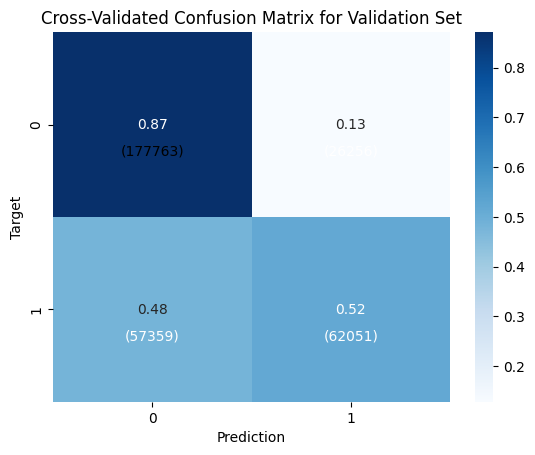

In [ ]:
train_compute_metrics_cv(lr, X_train_tfidf, y_train)

Train Metrics (averaged across folds):
Average Log loss: 0.53
Average Precision score: 0.73
Average Recall score: 0.43
Average F1 score: 0.54

Validation Metrics (averaged across folds):
Average Log loss: 0.54
Average Precision score: 0.73
Average Recall score: 0.43
Average F1 score: 0.54


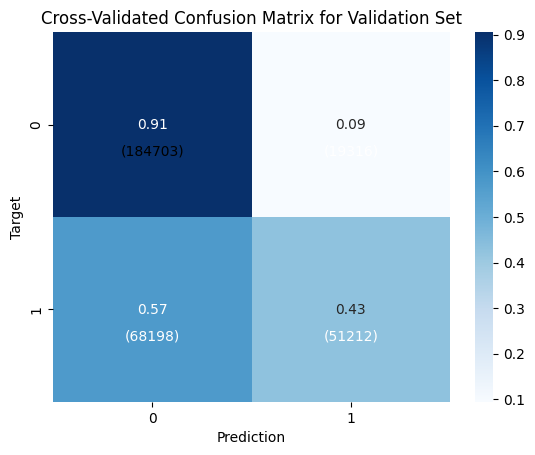

In [ ]:
nb = MultinomialNB()
train_compute_metrics_cv(nb, X_train_tfidf, y_train)

In [ ]:
xgb = XGBClassifier(objective='binary:logistic')

Train Metrics (averaged across folds):
Average Log loss: 0.52
Average Precision score: 0.82
Average Recall score: 0.38
Average F1 score: 0.52

Validation Metrics (averaged across folds):
Average Log loss: 0.54
Average Precision score: 0.79
Average Recall score: 0.36
Average F1 score: 0.49


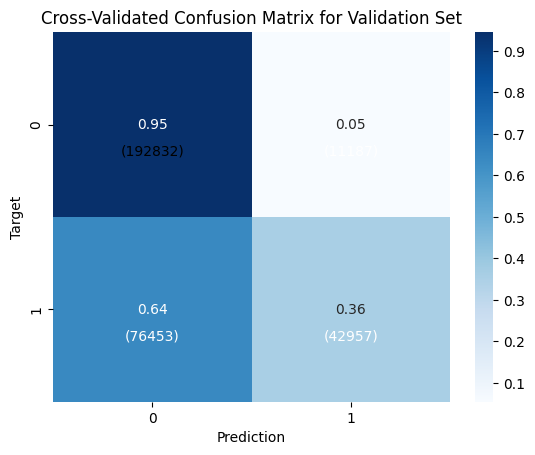

In [ ]:
train_compute_metrics_cv(xgb, X_train_tfidf, y_train)

Logistic Regression yields the best results.

# Text Similarity Metrics

The similarity metrics — cosine similarity, Euclidean distance, and Manhattan distance are useful for assessing how closely two sets of text embeddings are related.

Cosine Similarity measures the angular distance between two vectors, providing a scale-invariant measure of similarity that’s well-suited for text embeddings, where direction often matters more than magnitude.

Euclidean Distance gives a straightforward measure of the absolute difference between embeddings in multi-dimensional space, indicating how far apart the vectors are in their original scale.

Manhattan Distance calculates the total absolute differences along each dimension, which can be useful in certain cases where individual dimensions carry significant meaning.


In [ ]:
def calculate_similarity_metrics(embeddings_q1, embeddings_q2, batch_size=100):
    """
    Calculates similarity metrics (cosine similarity, Euclidean distance, and Manhattan distance)
    between two sets of BERT embeddings in batches.

    Args:
        embeddings_q1 (np.ndarray): Array of embeddings for the first set of questions.
        embeddings_q2 (np.ndarray): Array of embeddings for the second set of questions.
        batch_size (int): Number of samples to process in each batch.

    Returns:
        np.ndarray: Matrix containing cosine similarity, Euclidean distance, and Manhattan distance
                    for each pair of embeddings.
    """
    # Initialize an empty list to store similarity results for each batch
    similarity_metrics = []

    for i in range(0, embeddings_q1.shape[0], batch_size):
        # Extract a batch for question1 embeddings
        batch_q1 = embeddings_q1[i:i + batch_size]
        # Extract the corresponding batch for question2 embeddings
        batch_q2 = embeddings_q2[i:i + batch_size]

        # Compute cosine similarity for this batch
        cosine_similarities = np.sum(batch_q1 * batch_q2, axis=1) / (norm(batch_q1, axis=1) * norm(batch_q2, axis=1))

        # Compute Euclidean distance for this batch
        euclidean_distances = norm(batch_q1 - batch_q2, axis=1)

        # Compute Manhattan distance for this batch
        manhattan_distances = np.sum(np.abs(batch_q1 - batch_q2), axis=1)

        # Combine metrics for the batch and append to the list
        batch_metrics = np.column_stack((cosine_similarities, euclidean_distances, manhattan_distances))
        similarity_metrics.append(batch_metrics)

    # Stack all batches into a single matrix
    similarity_metrics_matrix = np.vstack(similarity_metrics)

    return similarity_metrics_matrix

In [ ]:
similarity_metrics_train = calculate_similarity_metrics(train_embeddings_q1, train_embeddings_q2)
similarity_metrics_test = calculate_similarity_metrics(test_embeddings_q1, test_embeddings_q2)

Let's train the models on similarity metrics:

Train Metrics (averaged across folds):
Average Log loss: 0.59
Average Precision score: 0.56
Average Recall score: 0.38
Average F1 score: 0.45

Validation Metrics (averaged across folds):
Average Log loss: 0.59
Average Precision score: 0.56
Average Recall score: 0.38
Average F1 score: 0.45


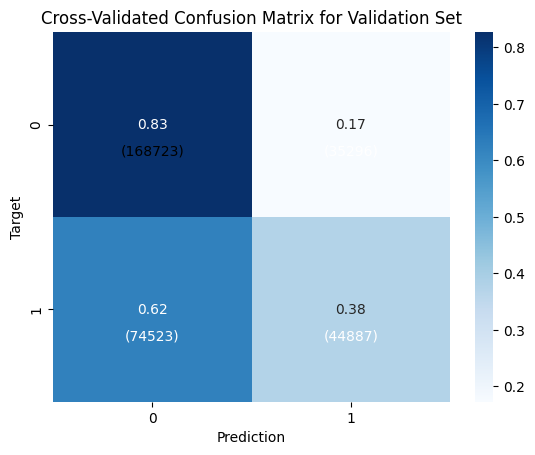

In [ ]:
lr = LogisticRegression(solver='sag')
train_compute_metrics_cv(lr, similarity_metrics_train, y_train)

Train Metrics (averaged across folds):
Average Log loss: 0.57
Average Precision score: 0.57
Average Recall score: 0.52
Average F1 score: 0.54

Validation Metrics (averaged across folds):
Average Log loss: 0.58
Average Precision score: 0.55
Average Recall score: 0.51
Average F1 score: 0.53


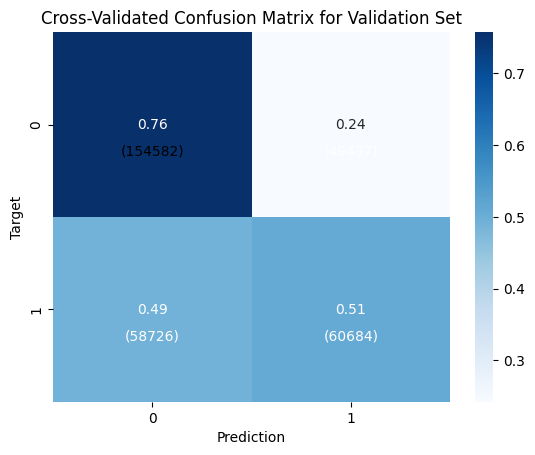

In [ ]:
xgb = XGBClassifier(objective='binary:logistic')
train_compute_metrics_cv(xgb, similarity_metrics_train, y_train)

These models give poor results. Let's train the models on TF-IDF embeddings + similarity metrics:

In [ ]:
# Stack the TF-IDF matrix and similarity metrics horizontally
X_train_combined = hstack([X_train_tfidf, csr_matrix(similarity_metrics_train)])
X_test_combined = hstack([X_test_tfidf, similarity_metrics_test])

Train Metrics (averaged across folds):
Average Log loss: 0.51
Average Precision score: 0.75
Average Recall score: 0.46
Average F1 score: 0.57

Validation Metrics (averaged across folds):
Average Log loss: 0.51
Average Precision score: 0.74
Average Recall score: 0.46
Average F1 score: 0.56


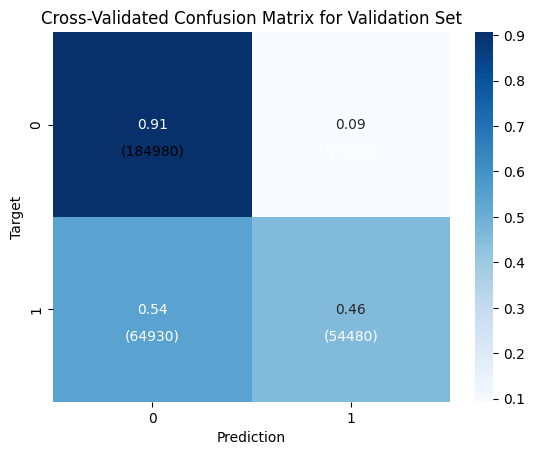

In [ ]:
nb = MultinomialNB()
train_compute_metrics_cv(nb, X_train_combined, y_train)

Train Metrics (averaged across folds):
Average Log loss: 0.45
Average Precision score: 0.73
Average Recall score: 0.64
Average F1 score: 0.68

Validation Metrics (averaged across folds):
Average Log loss: 0.46
Average Precision score: 0.72
Average Recall score: 0.62
Average F1 score: 0.67


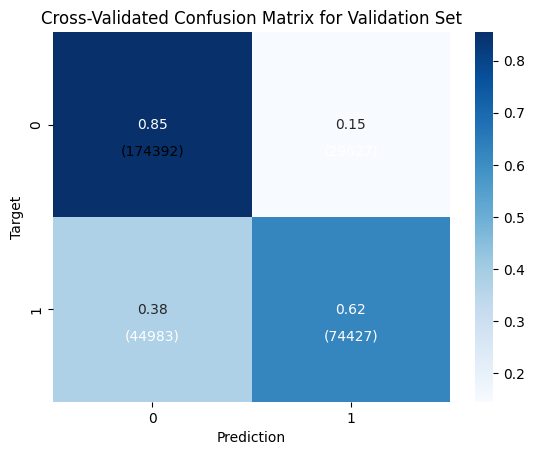

In [ ]:
lr = LogisticRegression(max_iter=4000)
train_compute_metrics_cv(lr, X_train_combined, y_train)

Train Metrics (averaged across folds):
Average Log loss: 0.47
Average Precision score: 0.72
Average Recall score: 0.63
Average F1 score: 0.67

Validation Metrics (averaged across folds):
Average Log loss: 0.48
Average Precision score: 0.70
Average Recall score: 0.61
Average F1 score: 0.66


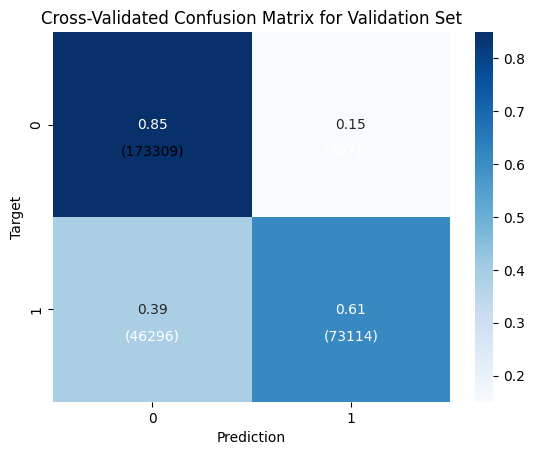

In [ ]:
xgb = XGBClassifier(objective='binary:logistic')
train_compute_metrics_cv(xgb, X_train_combined, y_train)

Linear Regression again yields the best results and the addition of similarity metrics to the data led to the better performance.

# BERT

In this section, we'll explore a custom model built on top of the pre-trained BERT model. The custom model consists of the BERT model followed by a classification layer, which enables the model to make predictions for our specific classification task.

Pre-trained BERT Model: The base BERT model is used to extract contextual embeddings from the input text. BERT is trained to capture relationships between words in a sentence.

Classification Layer: After BERT generates embeddings for the input text, the output is passed through a classification layer. The purpose of the classification layer is to take the representations from BERT and map them to predictions.

By using this custom model, we take advantage of BERT's rich language understanding and adapt it specifically for our classification problem.

In [52]:
class QuestionDataset(torch.utils.data.Dataset):
    def __init__(self, questions1, questions2, labels, tokenizer, max_length=128):
        self.questions1 = questions1
        self.questions2 = questions2
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.questions1)

    def __getitem__(self, idx):
        question1 = self.questions1[idx]
        question2 = self.questions2[idx]
        label = self.labels[idx]

        # Tokenize and encode the questions into input format for BERT
        encoding = self.tokenizer(
            question1,
            question2,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            return_overflowing_tokens=False
        )

        # Get the input_ids, attention_mask, and token_type_ids
        input_ids = encoding['input_ids'].squeeze(0)  # Remove the batch dimension
        attention_mask = encoding['attention_mask'].squeeze(0)
        token_type_ids = encoding['token_type_ids'].squeeze(0)

        # Return them in the required format
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [68]:
class DuplicateTextClassifier(nn.Module):
    def __init__(self, bert_model):
        super(DuplicateTextClassifier, self).__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)  # Output for classification

    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):
        # Forward pass through BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)

        # Use the [CLS] token embedding for classification
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        logits = self.classifier(cls_embedding)

        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

In [69]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Initialize your custom model
model = DuplicateTextClassifier(bert_model)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_steps=10_000,
    save_total_limit=2,
    report_to=[]
)

In [70]:
# Split training data into train and validation sets
train_df, val_df = train_test_split(df_train, test_size=0.2, stratify=df_train['is_duplicate'], random_state=42)

# Prepare the datasets
train_dataset = QuestionDataset(train_df['question1'].values,
                                           train_df['question2'].values,
                                           train_df['is_duplicate'].values,
                                           tokenizer)

val_dataset = QuestionDataset(val_df['question1'].values,
                                         val_df['question2'].values,
                                         val_df['is_duplicate'].values,
                                         tokenizer)

In [ ]:
# Define a function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    precision = precision_score(labels, preds, average="binary")
    recall = recall_score(labels, preds, average="binary")
    f1 = f1_score(labels, preds, average="binary")

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

In [ ]:
val_metrics = trainer.evaluate(eval_dataset=val_dataset)

In [86]:
val_metrics

{'eval_loss': 0.4485779404640198,
 'eval_precision': 0.8608988946684005,
 'eval_recall': 0.8870697596516205,
 'eval_f1': 0.8737884099814395,
 'eval_runtime': 159.3841,
 'eval_samples_per_second': 405.85,
 'eval_steps_per_second': 25.366,
 'epoch': 5.0}

This model outperforms all the other models. Let's check how it will perform on the test dataset:

In [ ]:
test_dataset = QuestionDataset(df_test['question1'].values,
                df_test['question2'].values,
                df_test['is_duplicate'].values,
                tokenizer)

predictions = trainer.predict(test_dataset)

preds = predictions.predictions
labels = predictions.label_ids
metrics = predictions.metrics

pred_labels = np.argmax(preds, axis=1)

In [73]:
metrics

{'test_loss': 0.4520483613014221,
 'test_precision': 0.8593810821331257,
 'test_recall': 0.8874484976384283,
 'test_f1': 0.8731893014287833,
 'test_runtime': 198.0386,
 'test_samples_per_second': 408.294,
 'test_steps_per_second': 25.52}

Log loss is relatively high, but the other metrics - precision, recall and f1 on the test dataset are really good.

#Incorrect Predictions Analysis


In [74]:
df_test['pred_labels'] = pred_labels

In [75]:
false_positives = df_test[(df_test['is_duplicate']==0) & (df_test['pred_labels']==1)]
false_negatives = df_test[(df_test['is_duplicate']==1) & (df_test['pred_labels']==0)]

In [79]:
false_positives.head(10)

,id,qid1,qid2,question1,question2,is_duplicate,pred_labels
15,352941,481920,481921,What is blacking out?,What is Black out?,0,1
25,221339,328668,7124,How do I raise funds for early stage startup?,What are the best ways to raise funds for a st...,0,1
57,220470,140081,327566,Can you get the same cold twice?,Can you get multiple colds at the same time?,0,1
67,232459,342484,342485,What are the impacts of population explosion?,Is India doomed with such high population expl...,0,1
76,365445,495560,495561,Is it good to be sober?,What is it like to be sober?,0,1
84,331429,458325,458326,How different would Harry Potter have been had...,If Harry Potter survived Voldemort's attack wh...,0,1
85,4380,8657,8658,How can I join indian army special forces?,How can I get into Indian army?,0,1
120,363808,493830,493831,How do elephants eat?,What do elephants eat?,0,1
122,388564,520974,55035,How can I start a successful startup?,How can I develop a startup?,0,1
161,247211,360397,121222,What are the disadvantages of whatsapp?,What are the advantages and disadvantages of W...,0,1


In [78]:
false_negatives.head(10)

,id,qid1,qid2,question1,question2,is_duplicate,pred_labels
10,72876,125134,125135,What is the best thing in pune?,What are the best things you can do in Pune?,1,0
48,71988,123786,123787,What's it like dating someone with a high IQ?,What is it like to date someone with a 150 IQ?,1,0
51,337921,157189,215866,When is it too late to study medicine and beco...,"I'm 37 years old, am I too old to go to school...",1,0
88,236072,59036,346907,How do I retrieve old chats after deleting a W...,How do I retrieve whatsapp chats from my old p...,1,0
97,208587,312626,312627,How many ways we can save water?,How we can save water?,1,0
101,58716,8143,102952,"Can India, Pakistan and Bangladesh unite?","Will India, Pakistan and Afghanistan ever unit...",1,0
117,365987,382231,496125,How accurate is Neil deGrasse Tyson's Cosmos?,What are the inaccuracies in Neil deGrasse Tys...,1,0
128,272067,390266,352395,Is there a limit to how much a supermassive bl...,Do black holes have a limit / max capacity?,1,0
153,57724,101406,101407,What is sympatric speciation? What are some ex...,What is speciation?,1,0
191,4273,8449,8450,What do teachers think of students who are mod...,What do teachers think of students?,1,0


Looking at this data, I think that model performance could be improved further if we improve the data, as most labels look very confusing (e.g. these questions are not considered duplicates - *'What is something everybody should know about your city/village/town?'	'What should everyone know about your city?'* but these are - *'Can India, Pakistan and Bangladesh unite?'	'Will India, Pakistan and Afghanistan ever unite and become one?'*).